## Basic imports

In [1]:
import sys
from tempfile import TemporaryDirectory
from scipy import stats 
from scipy import signal
import suite2p
import numpy as np
from tifffile import TiffFile, imwrite
import seaborn as sns
import os, glob
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import pandas as pd

# sys.path.append('/mnt/ssd1/ysaito/suite2p-pipeline-main/00_code/')
# import ROI_postprocess_YS.postprocess as post
# import importlib
# importlib.reload(post)

## Read metainfo

In [2]:
metainfo = h5py.File(os.getcwd()+'/00_Metafile/metafile.h5', 'r')
display(metainfo['sessionInfo'].keys())

recordingDate = metainfo['sessionInfo/recordingDate'][()].decode()
mouseID = metainfo['sessionInfo/mouseID'][()].decode()
behaviorInfo = metainfo['sessionInfo/behaviorInfo'][()].decode()
recTarget = metainfo['sessionInfo/recTarget'][()].decode()
sensor = metainfo['sessionInfo/sensor'][()].decode()
fs = metainfo['sessionInfo/fs'][()]
resolution = metainfo['sessionInfo/resolution'][()]
analysisDate = metainfo['sessionInfo/analysisDate'][()].decode()


codeDir = metainfo['sessionInfo/codeDir'][()].decode()
dataDir = metainfo['sessionInfo/sessiondataDir'][()].decode()
analysisDir = metainfo['sessionInfo/analysisDir'][()].decode()+'/01_ROI_detection' 
os.makedirs(analysisDir, exist_ok=True)
metainfo.close()

print('recording date:', recordingDate)
print('analysis date:', analysisDate)
print('behaviorInfo:', behaviorInfo)
print('sensor:', sensor)
print('recTarget:', recTarget)
print('fs:', fs)
print('resolution:', resolution)
print('dataDir:', dataDir)
print('analysisDir:', analysisDir)

<KeysViewHDF5 ['analysisDate', 'analysisDir', 'behaviorInfo', 'codeDir', 'fs', 'mouseID', 'opsin', 'recTarget', 'recordingDate', 'resolution', 'sensor', 'sessionID', 'sessiondataDir']>

recording date: 20231201
analysis date: 2024-07-11 11:43:01.228358
behaviorInfo: sponataneous
sensor: GCaMP7f
recTarget: Soma
fs: 15.2
resolution: 1024
dataDir: /mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1
analysisDir: /mnt/Volume3/FASHIO-2PM/with_Uwamori/02_analysis/u161_f01/20231201/Exp1/01_ROI_detection


## Data

In [3]:
tiff_list = sorted(glob.glob(dataDir+'/*.tiff'))
print('Input')
display(dataDir)
display(tiff_list)

Input


'/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1'

['/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-0.tiff',
 '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-1.tiff',
 '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-2.tiff',
 '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-3.tiff',
 '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-4.tiff']

# Suite2p

## Set parameters

In [4]:
ops = suite2p.default_ops()
print(ops)

{'suite2p_version': '0.14.4', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': '', 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.0, 'fs': 10.0, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': True, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 500, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': False, 'no

In [5]:
# Set parameters
db = {
    'data_path': dataDir,
    'save_path0': analysisDir,
    'tiff_list': tiff_list,
    'fs': fs,
    'tau': 2,
    'spatial_scale':1,
    'keep_movie_raw': False,
    'two_step_registration': False,
    'maxregshift':0.02, #0.1
    'smooth_sigma_time':0, #0
    'maxregshiftNR':40,    #5
    'th_badframes':1,
    'block_size': [256, 256],
    'batch_size': 1000,
    'subpixel':2,
    'threshold_scaling': 1.5,
    'connected': True,
    'sparse_mode': True,
    'max_iterations': 200,
    'max_overlap':0.25,
    'spikedetect': False,
}
db

{'data_path': '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1',
 'save_path0': '/mnt/Volume3/FASHIO-2PM/with_Uwamori/02_analysis/u161_f01/20231201/Exp1/01_ROI_detection',
 'tiff_list': ['/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-0.tiff',
  '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-1.tiff',
  '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-2.tiff',
  '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-3.tiff',
  '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-4.tiff'],
 'fs': 15.2,
 'tau': 2,
 'spatial_scale': 1,
 'keep_movie_raw': False,
 'two_step_registration': False,
 'maxregshift': 0.02,
 'smooth_sigma_time': 0,
 'maxregshiftNR': 40,
 'th_badframes': 1,
 'block_size': [256, 256],
 'batch_size': 1000,
 'subpixel': 2,
 'threshold_scaling': 1.5,
 'connected': True,
 'sparse_mode': True,
 'max_iterations': 200,

## Run suite2p

In [6]:
%%time
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1', 'save_path0': '/mnt/Volume3/FASHIO-2PM/with_Uwamori/02_analysis/u161_f01/20231201/Exp1/01_ROI_detection', 'tiff_list': ['/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-0.tiff', '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-1.tiff', '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-2.tiff', '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-3.tiff', '/mnt/Volume3/FASHIO-2PM/with_Uwamori/01_data/u161_f01/20231201/Exp1/Exp01_C1-4.tiff'], 'fs': 15.2, 'tau': 2, 'spatial_scale': 1, 'keep_movie_raw': False, 'two_step_registration': False, 'maxregshift': 0.02, 'smooth_sigma_time': 0, 'maxregshiftNR': 40, 'th_badframes': 1, 'block_size': [256, 256], 'batch_size': 1000, 'subpixel': 2, 'threshold_scaling': 1.5, 'connected': True, 'sparse_mode': True, 'max_iterations': 200, 'max_overlap': 0.25, 'spi

/mnt/Volume3/miniconda3/envs/network2/lib/python3.12/site-packages/suite2p/extraction/extract.py:125: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  Fi[n] = np.dot(data[:, cell_ipix[n]], cell_lam[n])


Extracted fluorescence from 8760 ROIs in 9500 frames, 44.86 sec.
----------- Total 72.17 sec.
----------- CLASSIFICATION
['npix_norm', 'skew', 'compact']
Plane 0 processed in 710.45 sec (can open in GUI).
total = 756.31 sec.
TOTAL RUNTIME 756.31 sec
CPU times: user 4h 5min 34s, sys: 34min 25s, total: 4h 39min 59s
Wall time: 12min 36s


## Load result

In [7]:
iscell = np.load(glob.glob(analysisDir+'/*/*/iscell.npy')[0], allow_pickle=True) #[:, 0].astype(bool)
np.save(analysisDir+'/suite2p/plane0/iscell_default.npy', iscell)

In [128]:
# iscell = np.load(glob.glob(analysisDir+'/*/*/iscell_default.npy')[0], allow_pickle=True) 
output_ops= np.load(glob.glob(analysisDir+'/*/*/ops.npy')[0], allow_pickle=True)
ROI_stats= np.load(glob.glob(analysisDir+'/*/*/stat.npy')[0], allow_pickle=True)
F = np.load(glob.glob(analysisDir+'/*/*/F.npy')[0], allow_pickle=True)
F_neuropils = np.load(glob.glob(analysisDir+'/*/*/Fneu.npy')[0], allow_pickle=True)

## Post-processing

In [130]:
iscell_2 = np.ones([ROI_stats.shape[0], 2])
clssify_parms = {
    'ROI_size_threshold':[15, 60],
    'ROI_compact_threshold': 1.1,
    'corr_np_threshold': 0.8,
    'max_dF_F_threshold': [1, 10],
    'min_dF_F_threshold': -0.6,
    'snr_threshold': 0.1,
    'noise_level_threshold':10,
    'noise_var_threshold':[0.0001,0.04]
}
clssify_parms

{'ROI_size_threshold': [15, 60],
 'ROI_compact_threshold': 1.1,
 'corr_np_threshold': 0.8,
 'max_dF_F_threshold': [1, 10],
 'min_dF_F_threshold': -0.6,
 'snr_threshold': 0.1,
 'noise_level_threshold': 10,
 'noise_var_threshold': [0.0001, 0.04]}

In [1]:
from suite2p import default_ops
def extract_ROI_stats(ROI_stats, key):
    key_stat = []
    for i in range(len(ROI_stats)):
        key_stat.append(ROI_stats[i][key])
    key_stat = np.array(key_stat)
    
    return key_stat

def calc_dF_F(F, F_neuropils, ops, db):
 
    from scipy.ndimage import percentile_filter
    ops = {**default_ops(), **ops, **db}
    #neuro pil substrcution
    Fcorr = F - 0.7*F_neuropils
    #calculate baseline
    # Fbase = percentile_filter(Fcorr, percentile=8, size=(1,int(ops['win_baseline']*ops['fs'])),axis=1)
    Fbase = percentile_filter(Fcorr, percentile=8, size=(int(ops['win_baseline']*ops['fs'])),axes=1)
    #calculate dF/F
    dF_F = (Fcorr-Fbase)/Fbase
    
    return dF_F

def calc_corr_np(F, F_neuropils):
    corr_np = []
    for i in range(F.shape[0]):
        corr_np.append(np.corrcoef(F[i],F_neuropils[i])[0][1])

    corr_np=np.array(corr_np)
    
    return corr_np

def calc_psd(dF_F, ops, db):
    from scipy import signal
    ops = {**default_ops(), **ops, **db}
    psd = []
    for i in range(dF_F.shape[0]):
        epoch=10#sec
        f, psd_= signal.welch(dF_F[i], ops['fs'], signal.windows.hann(int(epoch*ops['fs']), 'True'), 
                              int(epoch*ops['fs']), int(epoch*ops['fs'])/2, nfft=None, detrend='constant', 
                              return_onesided=True, scaling='density', axis=-1)

        # f, psd_= signal.welch(dF_F[i], ops['fs'], signal.hann(int(epoch*ops['fs']), 'True'), 
        #                       int(epoch*ops['fs']), int(epoch*ops['fs'])/2, nfft=None, detrend='constant', 
        #                       return_onesided=True, scaling='density', axis=-1)
        psd_norm = psd_ / np.max(psd_)
        psd.append(psd_norm)
    psd=np.array(psd)
    
    return f, psd

def calc_snr(dF_F, ops, db, signal_thr):
    ops = {**default_ops(), **ops, **db}
    snr=[]
    for i in range(dF_F.shape[0]):
        epoch=10#sec
        f, psd_ = signal.welch(dF_F[i], ops['fs'], signal.hann(int(epoch*ops['fs']), 'True'), 
                              int(epoch*ops['fs']), int(epoch*ops['fs'])/2, nfft=None, detrend='constant', 
                              return_onesided=True, scaling='density', axis=-1)
        psd_norm = psd_ / np.max(psd_)
        signal_freq_pw = sum(psd_norm[np.where(f<signal_thr)[0]])
        art_freq_pw = sum(psd_norm[np.where(f>=signal_thr)[0]])
        snr.append(signal_freq_pw/art_freq_pw)
    snr=np.array(snr)
    
    return snr

def calc_noise_variance(dF_F, low, high, fs):
    def bandpass(data, low, high, fs, order):
        '''
            bandpass filter
            Parameters
            ----------
            low: bandpass low
            high: bandpas high
            fs: sampling frequency
        '''
        from scipy.signal import butter, filtfilt
        nyq = fs/2
        low = low/nyq
        high = high/nyq
        b, a = butter(order, [low, high], btype='band')
        filtered_data = filtfilt(b, a, data, axis=1)
        return filtered_data
    
    filtered = bandpass(dF_F, low, high, fs, order=1)
    noise_variance = np.var(filtered, axis=1)
    
    return noise_variance

### Morphorogy

(0.0, 100.0)

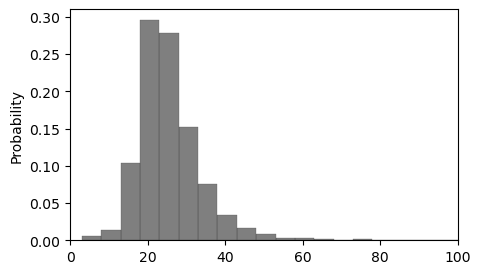

In [10]:
ROI_npix = extract_ROI_stats(ROI_stats, key='npix')
fig = plt.figure(figsize=(5, 3))
sns.histplot(ROI_npix, binwidth=5, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
plt.xlim(0,100)

(0.9, 1.3)

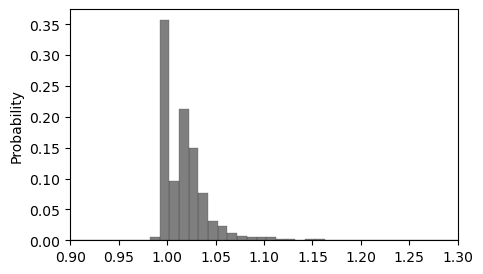

In [11]:
ROI_compact = extract_ROI_stats(ROI_stats, key='compact')
fig = plt.figure(figsize=(5, 3))
sns.histplot(ROI_compact, binwidth=0.01, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
plt.xlim(0.9,1.3)

In [12]:
centroid = extract_ROI_stats(ROI_stats, key='med')[:,::-1]

In [131]:
# Remove ROIs by morphology
outlier_ROI_size = np.where((ROI_npix<clssify_parms['ROI_size_threshold'][0]) | (ROI_npix>clssify_parms['ROI_size_threshold'][1]))[0]
iscell_2[outlier_ROI_size] = 0

outlier_aspect_ratio= np.where(ROI_compact>=clssify_parms['ROI_compact_threshold'])[0]
iscell_2[outlier_aspect_ratio] = 0

### Activity

In [24]:
dF_F = calc_dF_F(F, F_neuropils, ops, db)

In [25]:
time = np.arange(0, dF_F.shape[1], 1)/db['fs']

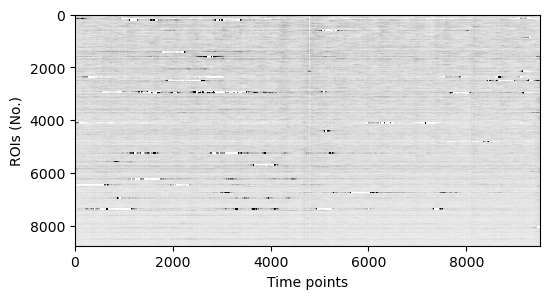

In [26]:
plt.figure(figsize=(6,3))
plt.imshow(dF_F, vmin = 0, vmax=3, aspect='auto', cmap='gray_r')
plt.xlabel('Time points')
plt.ylabel('ROIs (No.)')
plt.show()

In [28]:
# fig = plt.figure(figsize=(5, 3))
# sns.histplot(np.max(dF_F, axis=1), binwidth=1, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
# plt.xlim(0,50)

# fig = plt.figure(figsize=(5, 3))
# sns.histplot(np.min(dF_F,axis=1), binwidth=0.2, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
# plt.xlim(-3,0)

In [29]:
# # Tuning thresholds
# clssify_parms['max_dF_F_threshold']=[1, 10]
# clssify_parms['min_dF_F_threshold']=-0.5

In [132]:
outlier_ROI_fluo = np.where(np.mean(F,axis=1)-np.mean(F_neuropils, axis=1) < 0)[0]
iscell_2[outlier_ROI_fluo] = 0
outlier_ROI_dF_F = np.where((np.max(dF_F,axis=1)<clssify_parms['max_dF_F_threshold'][0])|(np.max(dF_F,axis=1)>clssify_parms['max_dF_F_threshold'][1]))[0]
iscell_2[outlier_ROI_dF_F] = 0
outlier_ROI_min_dF_F = np.where((np.min(dF_F,axis=1)<clssify_parms['min_dF_F_threshold']))[0]
iscell_2[outlier_ROI_min_dF_F] = 0

### Correlation with neuropils

/mnt/Volume3/miniconda3/envs/network2/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/Volume3/miniconda3/envs/network2/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


0.8


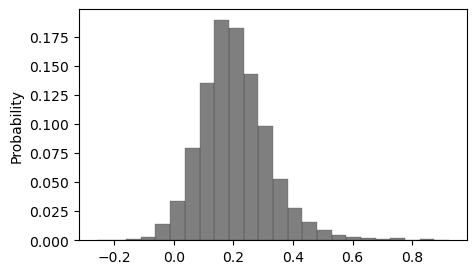

In [44]:
corr_np = calc_corr_np(F, F_neuropils)
fig = plt.figure(figsize=(5, 3))
sns.histplot(corr_np, binwidth=0.05, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
print(clssify_parms['corr_np_threshold'])

In [133]:
outlier_corr_np = np.where(corr_np>clssify_parms['corr_np_threshold'])[0]
iscell_2[outlier_corr_np] = 0

### Noise level
https://gcamp6f.com/2021/10/04/large-scale-calcium-imaging-noise-levels/

10


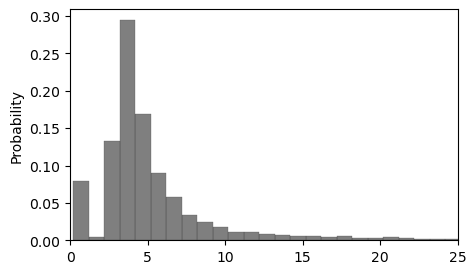

In [48]:
standarized_noise_level = np.median(abs(np.diff(dF_F,axis=1)*100)/np.sqrt(db['fs']),axis=1)
fig = plt.figure(figsize=(5, 3))
sns.histplot(standarized_noise_level, binwidth=1, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
plt.xlim(0,25)
print(clssify_parms['noise_level_threshold'])

Number of noisey ROIs: 853


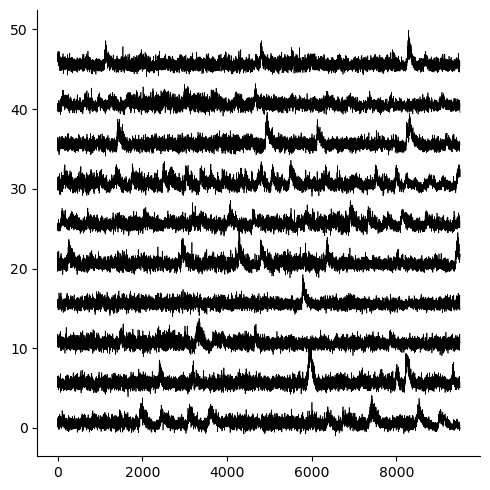

In [53]:
cellID = np.random.choice(np.where((standarized_noise_level>clssify_parms['noise_level_threshold'])&
                                   (standarized_noise_level<clssify_parms['noise_level_threshold']+1))[0], size=10, replace=False)
print('Number of noisey ROIs:', len(np.where(standarized_noise_level>clssify_parms['noise_level_threshold'])[0]))
fig = plt.figure(figsize=(5,5),tight_layout=True)
for i, v in enumerate(cellID):
    plt.plot(dF_F[v]+i*5, color='k', lw=0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [85]:
outlier_noise_level = np.where(standarized_noise_level>clssify_parms['noise_level_threshold'])[0]
iscell_2[outlier_noise_level] = 0

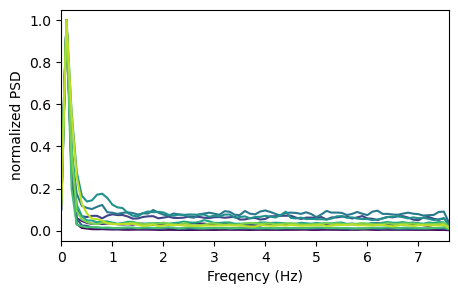

In [66]:
f, psd = calc_psd(dF_F, ops, db)
cellID = np.random.choice(dF_F.shape[0], size=10, replace=False)
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(5, 3))
for i, v in enumerate(cellID):
    plt.plot(f, psd[v], color=cmap(i/len(cellID)))
    plt.xlim(f.min(),f.max())
    plt.xlabel('Freqency (Hz)')
    plt.ylabel('normalized PSD')

Text(0, 0.5, 'Probability')

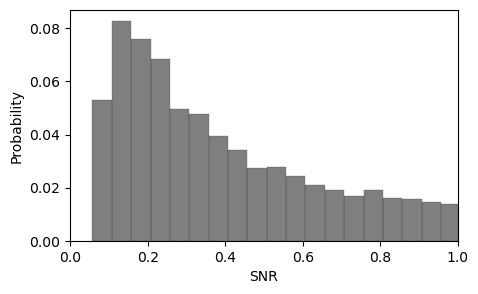

In [70]:
fig = plt.figure(figsize=(5, 3))
sns.histplot(snr, binwidth=0.05, stat='probability', kde=False, color='k', alpha=.5, linewidth=0.2, edgecolor='.3');
plt.xlim(0,1)
plt.xlabel('SNR')
plt.ylabel('Probability')

In [134]:
# # Tuning thresholds
# iscell_2 = np.ones([ROI_stats.shape[0], 2])
# clssify_parms['snr_threshold']=0.1
# clssify_parms['noise_var_threshold']=[0.0001, 0.04]

Number of low SNR ROIs: 368


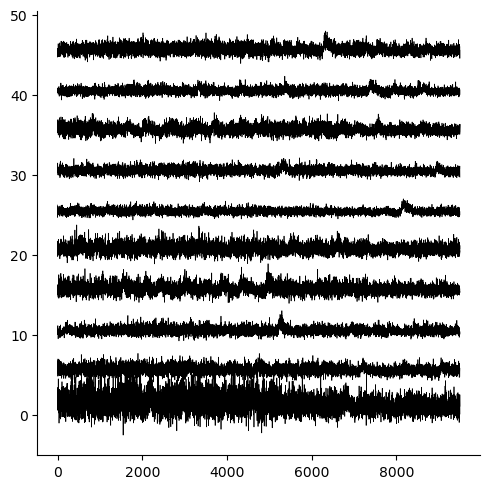

In [135]:
cellID = np.random.choice(np.where((snr<clssify_parms['snr_threshold'])&(snr>clssify_parms['snr_threshold']-0.025))[0], size=10, replace=False)
print('Number of low SNR ROIs:', len(np.where(snr<clssify_parms['snr_threshold'])[0]))
fig = plt.figure(figsize=(5,5),tight_layout=True)
for i, v in enumerate(cellID):
    plt.plot(dF_F[v]+i*5, color='k', lw=0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [136]:
noise_variance = calc_noise_variance(dF_F, low=6, high=7.5, fs=fs)

Number of noisey ROIs: 640


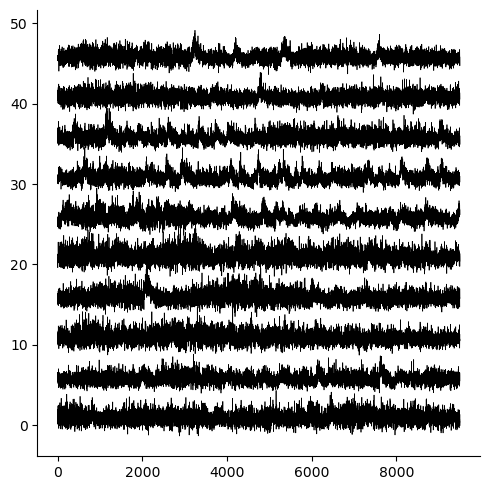

In [137]:
cellID = np.random.choice(np.where((noise_variance>clssify_parms['noise_var_threshold'][1])&
                                   (noise_variance<clssify_parms['noise_var_threshold'][1]+0.05))[0], size=10, replace=False)
print('Number of noisey ROIs:', len(np.where(noise_variance>clssify_parms['noise_var_threshold'][1])[0]))
fig = plt.figure(figsize=(5,5),tight_layout=True)
for i, v in enumerate(cellID):
    plt.plot(dF_F[v]+i*5, color='k', lw=0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [138]:
outlier_ROI_snr = np.where(snr<clssify_parms['snr_threshold'])[0]
outlier_ROI_noise = np.where((noise_variance>clssify_parms['noise_var_threshold'][1]) | (noise_variance<clssify_parms['noise_var_threshold'][0]))[0]
iscell_2[outlier_ROI_snr] = 0
iscell_2[outlier_ROI_noise] = 0

### Classified ROIs

cell number: 5344
non-cell number: 3416


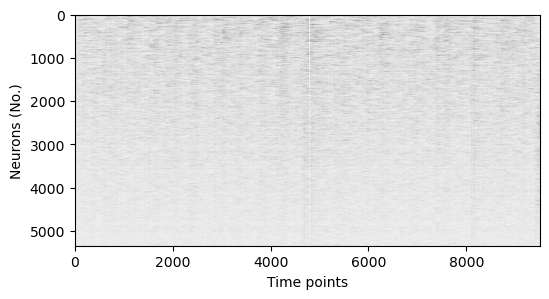

In [139]:
print('cell number:', len(np.where(iscell_2[:,1]==1)[0]))
print('non-cell number:', len(np.where(iscell_2[:,1]==0)[0]))
plt.figure(figsize=(6,3))
plt.imshow(dF_F[np.where(iscell_2[:,0]==1)[0]], vmin = 0, vmax=3, aspect='auto', cmap='gray_r')
plt.xlabel('Time points')
plt.ylabel('Neurons (No.)')
plt.show()

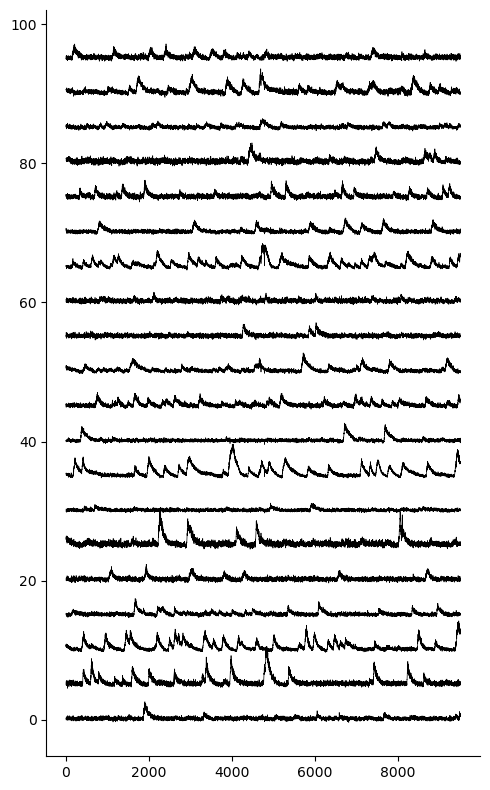

In [140]:
cellID = np.random.choice(np.where(iscell_2[:,0]==1)[0], size=20, replace=False)
fig = plt.figure(figsize=(5,8),tight_layout=True)
for i, v in enumerate(cellID):
    plt.plot(dF_F[v]+i*5, color='k', lw=0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [141]:
np.save(analysisDir+'/suite2p/plane0/iscell.npy', iscell_2)

## Check ROI quality with GUI

In [150]:
!suite2p

/mnt/Volume3/FASHIO-2PM/with_Uwamori/02_analysis/u161_f01/20231201/Exp1/01_ROI_detection/suite2p/plane0/stat.npy
no channel 2 labels found (redcell.npy)
time to draw and plot masks:  2.6667 sec


## Denoise & spike inference

In [151]:
from oasis.functions import deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

/mnt/Volume3/miniconda3/envs/network2/lib/python3.12/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [157]:
def baseline_corr(F, fs, baseline='maximin', sig_baseline = 10, win_baseline=60, prctile_baseline=15):
    '''
    From suite2p
    sig_baseline:in bins, standard deviation of gaussian with which to smooth
    win_baseline:in seconds, window in which to compute max/min filters
    '''
    from scipy.ndimage import maximum_filter1d, minimum_filter1d, gaussian_filter, percentile_filter
    win = int(win_baseline * fs)
    if baseline == "maximin":
        Flow = gaussian_filter(F, [0., sig_baseline])
        Flow = minimum_filter1d(Flow, win)
        Flow = maximum_filter1d(Flow, win)
    elif baseline == "constant":
        Flow = gaussian_filter(F, [0., sig_baseline])
        Flow = np.amin(Flow)
    elif baseline == "constant_prctile":
        Flow = np.percentile(F, prctile_baseline, axis=1)
        Flow = np.expand_dims(Flow, axis=1)
    elif baseline == "percentile":
        Flow = percentile_filter(F, percentile=prctile_baseline, size=win, axes=1)
    elif baseline == "constant_median":
        Flow = np.median(F, axis=1)
        Flow = np.expand_dims(Flow, axis=1)
    Fcorr = F - Flow
    
    return Fcorr

In [152]:
def plot_trace(time, dF_F, c, s):
    plt.figure(figsize=(10,3))
    plt.subplot(311)
    plt.plot(time, dF_F, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.9))
    plt.xlim(time.min(), time.max())
    plt.ylim(-0.5,5)
    simpleaxis(plt.gca())
    
    plt.subplot(312)
    plt.plot(time, c, lw=2, label='denoised')
    plt.plot(time, dF_F, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.9))
    plt.xlim(time.min(), time.max())
    plt.ylim(-0.5,5)
    simpleaxis(plt.gca())
    
    plt.subplot(313)
    plt.plot(time, s, lw=2, label='deconvolved', c='g')
    plt.ylim(0,1.5)
    plt.legend(ncol=3, frameon=False, loc=(.02,.9));
    simpleaxis(plt.gca())
    plt.xlim(time.min(), time.max())
    plt.xlabel('Time (sec)')
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

In [159]:
corrected_dF_F=baseline_corr(dF_F, fs=db['fs'], baseline='maximin', sig_baseline = 10, win_baseline=60, prctile_baseline=15)

In [161]:
inf_parms = {
    's_min':.3
}
inf_parms

{'s_min': 0.3}

/tmp/ipykernel_1756686/2710220414.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c, s = oasisAR1(corrected_dF_F[i].astype('double'), g=estimate_parameters(corrected_dF_F[i], p=1, lags=200)[0], s_min=inf_parms['s_min'])


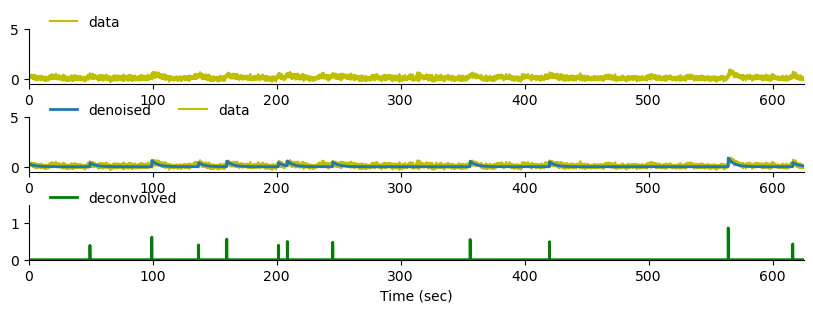

<Figure size 1000x150 with 0 Axes>

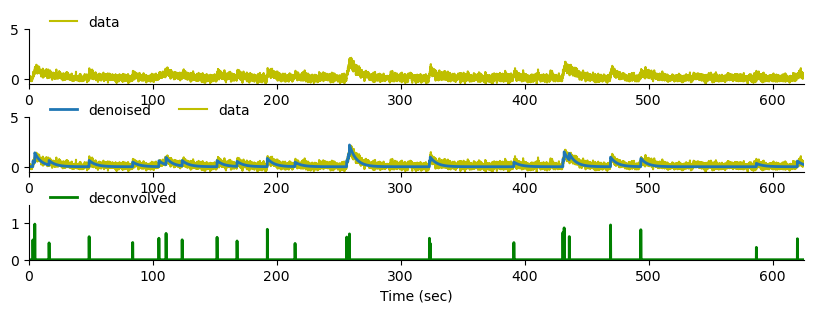

<Figure size 1000x150 with 0 Axes>

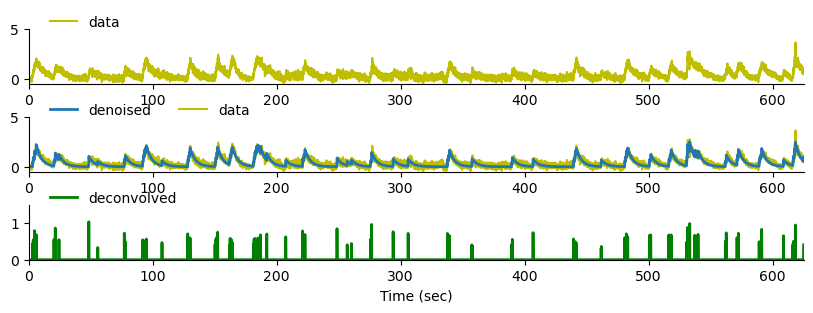

<Figure size 1000x150 with 0 Axes>

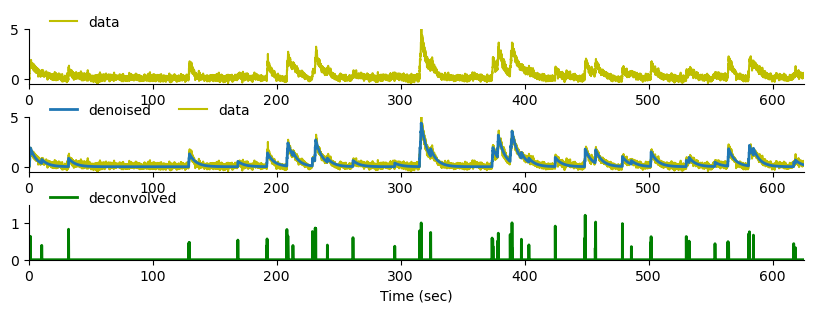

<Figure size 1000x150 with 0 Axes>

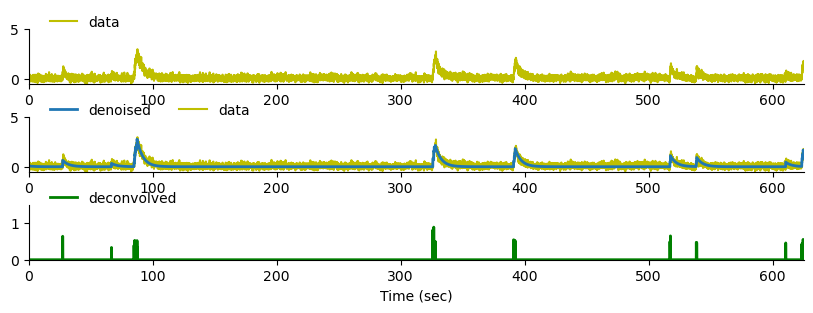

<Figure size 1000x150 with 0 Axes>

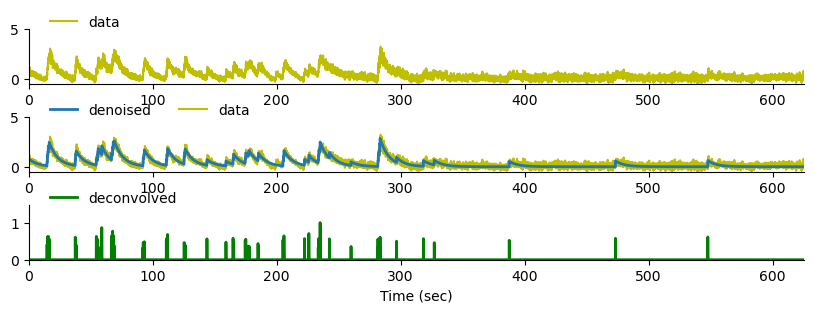

<Figure size 1000x150 with 0 Axes>

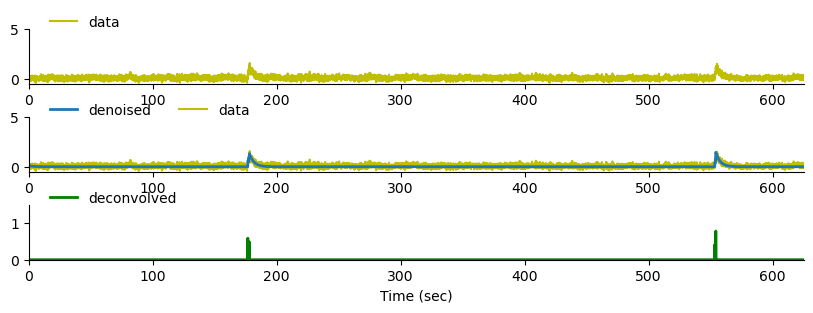

<Figure size 1000x150 with 0 Axes>

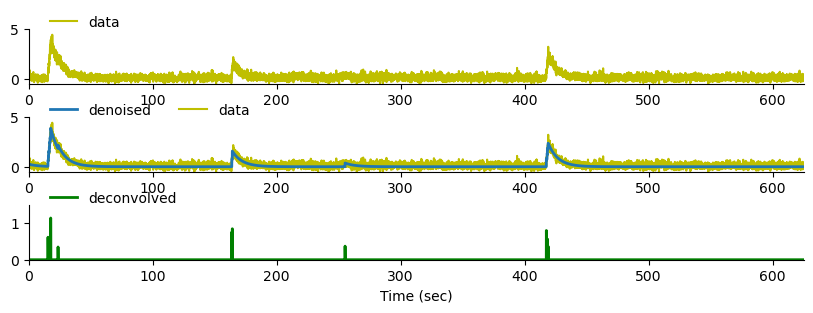

<Figure size 1000x150 with 0 Axes>

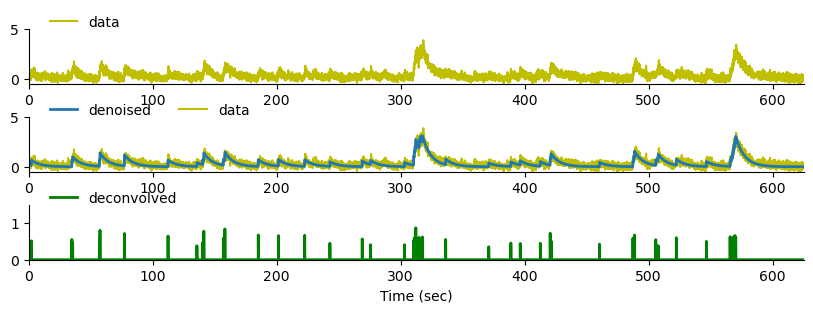

<Figure size 1000x150 with 0 Axes>

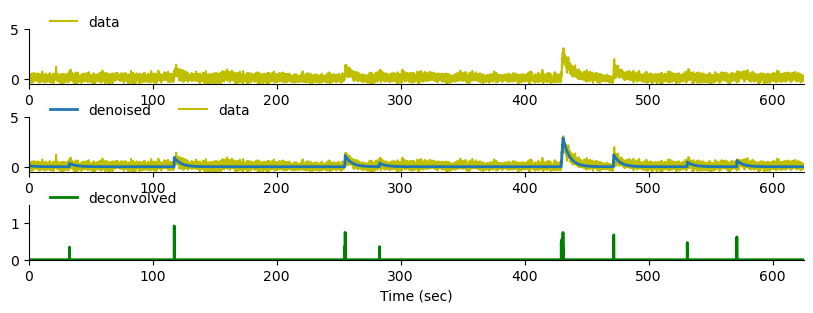

<Figure size 1000x150 with 0 Axes>

In [162]:
# check parameter before apply oasis in whole data
cellID = np.random.choice(np.where(iscell_2[:,0]==1)[0], size=10, replace=False)
for i in cellID:
    # c, s = oasisAR1(corrected_dF_F[i].astype('double'), g=estimate_parameters(corrected_dF_F[i], p=1,range_ff=[0.2, 0.5], lags=200)[0], s_min=inf_parms['s_min'])
    c, s = oasisAR1(corrected_dF_F[i].astype('double'), g=estimate_parameters(corrected_dF_F[i], p=1, lags=200)[0], s_min=inf_parms['s_min'])
    plot_trace(time, corrected_dF_F[i], c, s)
    plt.figure(figsize=(10,1.5))

In [163]:
%%time
denoise = []
deconv = []
for i in range(dF_F.shape[0]):
    c, s = oasisAR1(corrected_dF_F[i].astype('double'), g=estimate_parameters(corrected_dF_F[i], p=1, lags=200)[0], s_min=inf_parms['s_min'])
    denoise.append(c)
    deconv.append(s)
denoise=np.array(denoise)
deconv=np.array(deconv)

<timed exec>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


CPU times: user 12.2 s, sys: 695 ms, total: 12.9 s
Wall time: 12.9 s


cell number: 5344
non-cell number: 3416


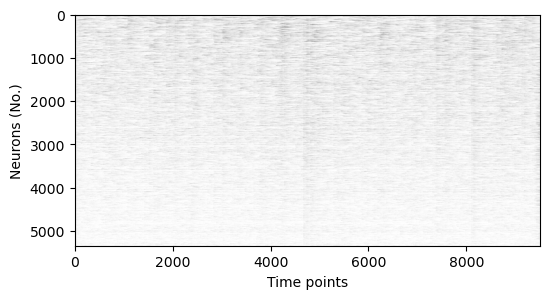

In [164]:
print('cell number:', len(np.where(iscell_2[:,1]==1)[0]))
print('non-cell number:', len(np.where(iscell_2[:,1]==0)[0]))
plt.figure(figsize=(6,3))
plt.imshow(denoise[np.where(iscell_2[:,0]==1)[0]], vmin = 0, vmax=3, aspect='auto', cmap='gray_r')
plt.xlabel('Time points')
plt.ylabel('Neurons (No.)')
plt.show()

In [102]:
# Remove ROI with no activity
iscell_2[np.where(np.sum(deconv,axis=1)==0)[0]] = 0
np.save(analysisDir+'/suite2p/plane0/iscell.npy', iscell_2)

## Save results as h5

In [165]:
with h5py.File(analysisDir+'/suite2p/plane0/roi_data.h5', mode='w') as f:
    f.create_dataset('dF_F', data=corrected_dF_F)
    f.create_dataset('denoise', data=denoise)
    f.create_dataset('deconv', data=deconv)
    f.create_dataset('celluse', data=iscell_2[:,0].astype('int'))
    f.create_dataset('snr', data=snr)
    f.create_dataset('roi_size', data=ROI_npix)
    f.create_dataset('centroid', data=centroid) 
    f.create_group('clssify_parms')
    for p in clssify_parms.keys():
        f.create_dataset('clssify_parms/'+p, data=clssify_parms[p])
    f.create_group('inf_parms')
    f.create_dataset('inf_parms/s_min', data=inf_parms['s_min'])  

In [104]:
# # Code for loading data
# roi_data = h5py.File(out_path+'/suite2p/plane0/roi_data.h5', mode='r')
# dF_F = np.array(list(roi_data['dF_F']))
# denoise = np.array(list(roi_data['denoise']))
# deconv = np.array(list(roi_data['deconv']))
# celluse = np.array(list(roi_data['celluse']))
# snr = np.array(list(roi_data['snr']))
# centroid = np.array(list(roi_data['centroid']))
# ROI_size_threshold = roi_data['clssify_parms/ROI_size_threshold'][()]
# roi_data.close()